# Centre candidates and clustering

An image processing pipeline to detect and localize Drosophila egg chambers that consists of the following steps: (i) superpixel-based image segmentation into relevant tissue classes (see above); (ii) detection of egg center candidates using label histograms and ray features; (iii) clustering of center candidates. 
Prepare zones for training center candidates and perfom desity clustering.

Borovec, J., Kybic, J., & Nava, R. (2017). **Detection and Localization of Drosophila Egg Chambers in Microscopy Images.** In Q. Wang, Y. Shi, H.-I. Suk, & K. Suzuki (Eds.), Machine Learning in Medical Imaging, (pp. 19–26).

In [1]:
%matplotlib inline
import os, sys
import numpy as np
from PIL import Image
from sklearn import cluster
import matplotlib.pylab as plt

In [8]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_io
import segmentation.ellipse_fitting as seg_fit
import segmentation.descriptors as seg_fts
import segmentation.classification as seg_clf

## Load images

In [3]:
name = 'insitu7545'
PATH_BASE = tl_io.update_path(os.path.join('images', 'drosophila_ovary_slice'))
PATH_IMAGES = os.path.join(PATH_BASE, 'image')
PATH_SEGM = os.path.join(PATH_BASE, 'segm')
PATH_ANNOT = os.path.join(PATH_BASE, 'annot_eggs')
PATH_CENTRE = os.path.join(PATH_BASE, 'center_levels')
COLORS = 'bgrcymk'

In [4]:
img = np.array(Image.open(os.path.join(PATH_IMAGES, name + '.jpg')))
segm = np.array(Image.open(os.path.join(PATH_SEGM, name + '.png')))
annot = np.array(Image.open(os.path.join(PATH_ANNOT, name + '.png')))
levels = np.array(Image.open(os.path.join(PATH_CENTRE, name + '.png')))
FIG_SIZE = (10. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]

## Show training for center detection

In this part we discuss the procedure of preparing training data...

### Individual egg annotation

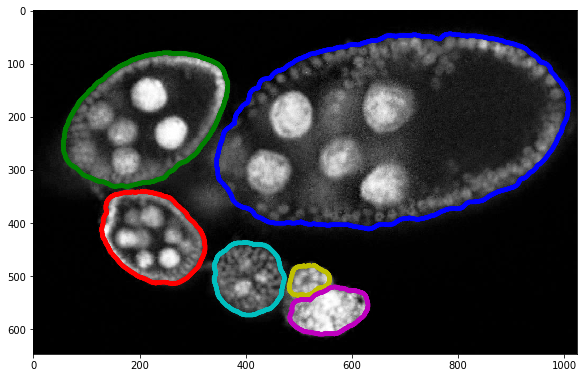

In [5]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
# _= plt.contour(annot, levels=np.unique(annot), linewidths=(4,))
for i in range(1, np.max(annot) + 1):
    _= plt.contour(annot == i, colors=COLORS[(i-1) % len(COLORS)], linewidths=(4,))

### Zones inside eggs

We have generated zones inside each objetc/egg such as we divide into 3 centric shapes.
In fact this annotation can be automatly created by oour scipt and then manually adjasted.

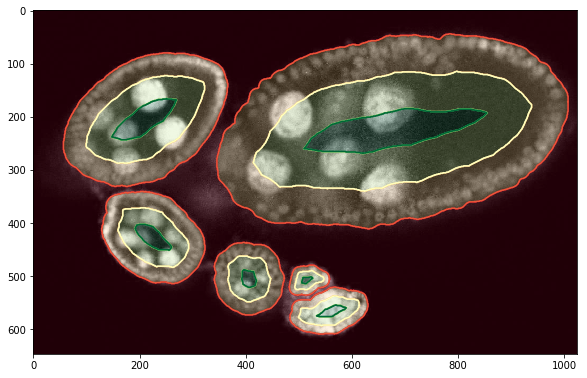

In [6]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
_= plt.imshow(levels, alpha=0.2, cmap=plt.cm.RdYlGn), plt.contour(levels, cmap=plt.cm.RdYlGn)

### Training examples, points

We assume that the center zone is postive (green), background and near boundary is negative (red) and the zone in between we ignore (blue).

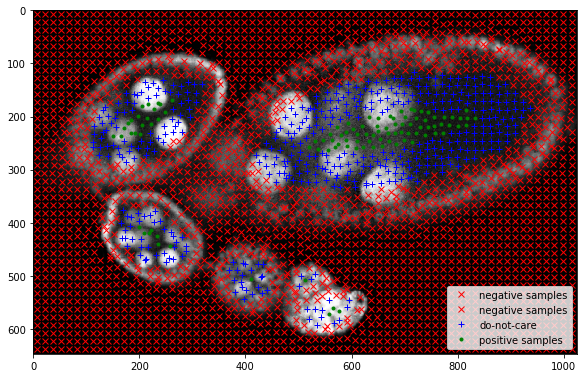

In [6]:
slic, points, labels = seg_fit.get_slic_points_labels(levels, img, size=15, regul=0.3)
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.plot(points[labels == 0, 1], points[labels == 0, 0], 'xr', label='negative samples')
plt.plot(points[labels == 1, 1], points[labels == 1, 0], 'xr', label='negative samples')
plt.plot(points[labels == 2, 1], points[labels == 2, 0], '+b', label='do-not-care')
plt.plot(points[labels == 3, 1], points[labels == 3, 0], '.g', label='positive samples')
_= plt.xlim([0, img.shape[1]]), plt.ylim([img.shape[0], 0]), plt.legend(loc='lower right')

Feature extraction for each sample point.

In [11]:
features_hist, names_hist = seg_fts.compute_label_histograms_positions(segm, points, diameters=[25, 50, 100, 150, 200, 300])
features_ray, _, names_ray = seg_fts.compute_ray_features_positions(segm, points, angle_step=15, edge='up', border_labels=[0], smooth_ray=0)
features = np.hstack((features_hist, features_ray))

Adjustment the annotation as we decribed before and train a classifier...

In [13]:
clf_pipeline = seg_clf.create_clf_pipeline()
labels[labels == 1] = 0
labels[labels == 3] = 2
clf_pipeline.fit(features, labels)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classif', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini'...mators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Predict lables for these sample points, note that overfitting may appeare.

In [16]:
labels = clf_pipeline.predict(features)
candidates = points[labels == 2, :]

# Center clustering

Visualisation of predicted positive sample points...

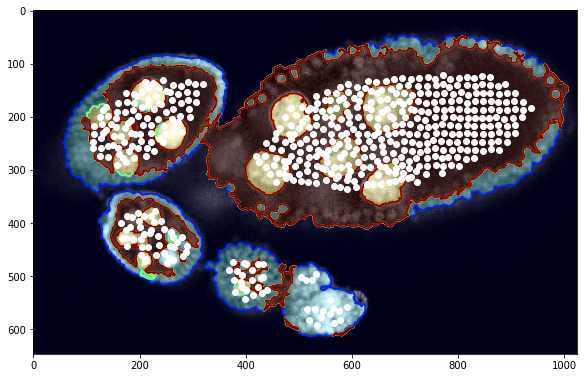

In [17]:
# candidates = points[labels == 3, :]
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.imshow(segm, alpha=0.2, cmap=plt.cm.jet), plt.contour(segm, cmap=plt.cm.jet)
_= plt.plot(candidates[:, 1], candidates[:, 0], 'ow')

As you can see that potentila points inside egg are more less grouped together. We apply decity clustering which alloes us to identify individual eggs.

In [9]:
dbscan = cluster.DBSCAN(eps=50, min_samples=1)
dbscan.fit(candidates)

DBSCAN(algorithm='auto', eps=50, leaf_size=30, metric='euclidean',
    min_samples=1, n_jobs=1, p=None)

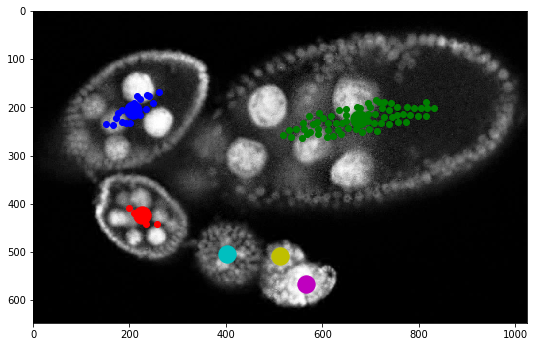

In [10]:
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
# plt.imshow(seg, alpha=0.2), plt.contour(seg)
centers = []

for i in range(max(dbscan.labels_) + 1):
    select = candidates[dbscan.labels_ == i]
    centers.append(np.mean(select, axis=0))
    plt.plot(select[:, 1], select[:, 0], 'o', color=COLORS[i % len(COLORS)])
centers = np.array(centers)

for i in range(len(centers)):
    fig.gca().scatter(centers[i, 1], centers[i, 0], s=300, c=COLORS[i % len(COLORS)])
    # plt.plot(centers[i, 1], centers[i, 0], 'o', color=COLORS[i % len(COLORS)])
_= plt.xlim([0, img.shape[1]]), plt.ylim([img.shape[0], 0])